In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [5]:
# #############################################################################
# Load data
# Boston house-prices dataset (regression)

#TO DO - test on more datasets if variance within the algorithm is negligble
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.7)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [6]:
# #############################################################################
# Fit regression model
# n_estimators : int (default=100) The number of boosting stages to perform.
# learning_rate : float, optional (default=0.1) learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
# max_depth : integer, optional (default=3) maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.
# min_samples_split : int, float, optional (default=2) The minimum number of samples required to split an internal node
# loss : (default=’ls’) loss function to be optimized. ‘ls’ refers to least squares regression.

pred_y_all = []

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
for i in range(10):
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)
    pred_y_i = clf.predict(X_test)
    pred_y_all.append(pred_y_i)
    mse = mean_squared_error(y_test, pred_y_i)
    print("MSE: %.4f" % mse)

MSE: 9.8826
MSE: 10.0895
MSE: 9.8977
MSE: 9.7963
MSE: 9.6880
MSE: 9.7426
MSE: 10.1237
MSE: 10.0916
MSE: 9.8951
MSE: 9.7073


In [9]:
np.corrcoef(pred_y_all[1], pred_y_all[2])


array([[ 1.        ,  0.99993081],
       [ 0.99993081,  1.        ]])

Text(0, 0.5, 'Deviance')

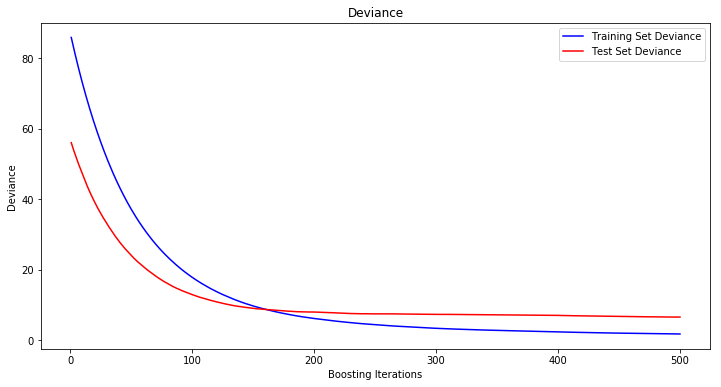

In [6]:
# #############################################################################
# Plot training deviance

# The figure below shows the results of applying GradientBoostingRegressor with least squares loss and 500 base learners 
# to the Boston house price dataset (sklearn.datasets.load_boston). It shows the train and test error at each 
# iteration. The train error at each iteration is stored in the train_score_ attribute of the gradient boosting model. The test 
# error at each iterations can be obtained via the staged_predict method which returns a generator that yields the predictions 
# at each stage. Plots like these can be used to determine the optimal number of trees (i.e. n_estimators) by early stopping.

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [ ]:
# TO DO -- compare y_pred of another python boosting implementation
# for e.g. here - https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d